In [1]:
#Installing Packages
!pip install stable-baselines3 gymnasium SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 37.8 MB/s eta 0:00:00


In [ ]:
#Importing packages and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium as gym

**PEM Electrolyser Environment**

In [3]:
# Simplified and robust environment
class ElectrolyserEnv(gym.Env):
    def __init__(self, episode_len=50, seed=None):  # Shorter episodes for faster learning
        super().__init__()
         # Initialise environment parameters
        self.episode_len = episode_len
        self.rng = np.random.default_rng(seed)
        self.t = 0   # Time step counter

        # Action space: single value for current density adjustment (-0.1 to 0.1)
        self.action_space = gym.spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)

        # Observation space: voltage, current density, temperature, pressure, flow rate, power input
        self.observation_space = gym.spaces.Box(
            low=np.array([1.2, 0.0, 20.0, 0.5, 0.0, 0.0], dtype=np.float32),
            high=np.array([2.4, 3.0, 100.0, 40.0, 120.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

        # Target and safety limits for the electrolyser
        self.v_opt = 1.8          # Optimal voltage setpoint
        self.j_min, self.j_max = 0.1, 2.0   # Current density limits (A/cm^2)
        self.v_min, self.v_max = 1.6, 2.0   # Voltage limits (V)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)     # Reset the random generator with a new seed
        self.t = 0  # Reset the timestep counter
        # Simple initial state
        self.state = np.array([
            self.v_opt + self.rng.normal(0, 0.05),      # Voltage with some noise
            self.rng.uniform(0.5, 1.0),                 # Current density (A/cm^2)
            self.rng.uniform(50, 70),                   # Temperature (°C)
            self.rng.uniform(8, 12),                    # Pressure (bar)
            self.rng.uniform(15, 25),                   # Flow rate (g/s)
            self.rng.uniform(0.4, 0.8)                  # Power input
        ], dtype=np.float32)
        return self.state.copy(), {}                    # Return the initial state with an empty info dictionary

    def step(self, action):
        self.t += 1                                     # Increment timestep counter
        v, j, temp, press, flow, pin = self.state       # Unpack the current state

        # Apply action (adjust the current density)
        j_new = np.clip(j + float(action[0]), self.j_min, self.j_max)

        # Simple deterministic dynamics for stability
        v_new = 1.5 + 0.18 * j_new                # Voltage as a function of current density
        temp_new = temp + 0.1 * j_new             # Temperature increases with current density
        press_new = press + 0.05 * j_new          # Pressure increases with current density
        flow_new = flow + 1.0 * j_new             # Flow rate increases with current density
        pin_new = 0.6 + 0.2 * np.sin(self.t / 10)  # Simple oscillating power input

         # Update the state with the new values, ensuring they stay within limits
        self.state = np.array([
            np.clip(v_new, 1.2, 2.4),             # Voltage within bounds
            np.clip(j_new, 0.0, 3.0),             # Current density within bounds
            np.clip(temp_new, 20.0, 100.0),       # Temperature within bounds
            np.clip(press_new, 0.5, 40.0),        # Pressure within bounds
            np.clip(flow_new, 0.0, 120.0),        # Flow rate within bounds
            np.clip(pin_new, 0.0, 1.0)            # Power input within bounds
        ], dtype=np.float32)

        # SIMPLIFIED Reward function - larger penalty for safety violations
        efficiency = (j_new / self.j_max) * pin_new  # Efficiency is proportional to current density and power input
        safety_penalty = 0.0                         # Safety penalty initialization
        if v_new < self.v_min or v_new > self.v_max:
            safety_penalty += 2.0                    # Penalty for violating voltage limits
        if j_new < self.j_min or j_new > self.j_max:
            safety_penalty += 2.0                    # Penalty for violating current density limits

        reward = 100 * efficiency - 50 * safety_penalty - 20 * abs(v_new - self.v_opt)  # Combine efficiency, safety, and stability penalties

        # Episode termination conditions
        terminated = False
        truncated = self.t >= self.episode_len

        return self.state.copy(), float(reward), terminated, truncated, {}

In [4]:
# Simple Callback
class SimpleCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []    # List to store the total rewards for each episode
        self.current_reward = 0      # Initialize the current episode reward

    def _on_step(self):
        # Check if rewards are available in the current step's locals
        if 'rewards' in self.locals and len(self.locals['rewards']) > 0:
            # Add the reward from the current step to the cumulative reward
            self.current_reward += float(self.locals['rewards'][0])

        # Check if the episode has ended (done flag)
        if 'dones' in self.locals and len(self.locals['dones']) > 0 and self.locals['dones'][0]:
            # Store the total reward for the current episode and reset for the next episode
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0   # Reset current reward for the next episode

        return True # Continue training

In [5]:
# Test if learning works
def test_single_training():
    print("Testing if learning works")

    # Create a vectorized environment (DummyVecEnv) with the ElectrolyserEnv
    env = DummyVecEnv([lambda: ElectrolyserEnv(episode_len=50, seed=42)])
    # Initialise the callback to track the rewards during training
    callback = SimpleCallback()

    # Set up the PPO model with specified hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,     # Learning rate for optimization
        clip_range=0.2,         # Clip range for PPO (adjusting policy updates)
        ent_coef=0.01,          # Entropy coefficient for regularization
        verbose=1,              # Verbosity level (1 means logging)
    )
    # Train the model
    model.learn(total_timesteps=10000, callback=callback)
    # After training, print the final reward and the progression
    if callback.episode_rewards:
        print(f"Final episode reward: {callback.episode_rewards[-1]:.1f}")
        print(f"Reward progression: {callback.episode_rewards[:5]} ... {callback.episode_rewards[-5:]}")
        return True, callback.episode_rewards[-1]
    else:
        print("No episode rewards recorded")
        return False, 0

# Run the test
success, final_reward = test_single_training()

if success:
    # Sensitivity analysis function
    print(f"✓ Learning successful! Final reward: {final_reward:.1f}")

    # Now run sensitivity analysis
    def train_and_evaluate(params, total_timesteps=8000):
        lr, clip_range, ent_coef = params     # Unpack the parameters

        # Create the environment and the callback
        env = DummyVecEnv([lambda: ElectrolyserEnv(episode_len=50, seed=42)])
        callback = SimpleCallback()

        try:
            # InitialiSe the PPO model with the given hyperparameters
            model = PPO(
                "MlpPolicy",
                env,
                learning_rate=lr,
                clip_range=clip_range,
                ent_coef=ent_coef,
                verbose=0,     # No verbose output during training
            )

            # Train the model
            model.learn(total_timesteps=total_timesteps, callback=callback)
            # Evaluate the model based on episode rewards
            if callback.episode_rewards:
                avg_reward = np.mean(callback.episode_rewards[-3:])  # Average of the last 3 episodes
            else:
                # Fallback evaluation: manually run episodes if no rewards are recorded
                eval_env = DummyVecEnv([lambda: ElectrolyserEnv(episode_len=20, seed=42)])
                obs = eval_env.reset()
                total_r = 0
                for _ in range(3):      # Run 3 evaluation episodes
                    done = [False]
                    while not done[0]:
                        action, _ = model.predict(obs, deterministic=True)
                        obs, reward, done, _ = eval_env.step(action)
                        total_r += reward[0]
                avg_reward = total_r / 3   # Average reward over 3 evaluation episodes

            print(f"Params: lr={lr:.1e}, clip={clip_range:.2f}, ent={ent_coef:.3f} → Reward: {avg_reward:.1f}")
            return avg_reward

        except Exception as e:
            print(f"Error: {e}")
            return -1000

    # Sensitivity analysis
    problem = {
        'num_vars': 3,                                               # Number of variables being tested
        'names': ['learning_rate', 'clip_range', 'entropy_coef'],    # Names of the variables
        'bounds': [
            [1e-5, 1e-2],   # Range for learning rate
            [0.1, 0.5],     # Range for clip range
            [1e-4, 0.1]     # Range for entropy coefficient
        ]
    }

    param_values = morris.sample(problem, N=15, num_levels=4)       # Sample parameter combinations for sensitivity analysis using the Morris method
    results = []

    print("\nStarting sensitivity analysis...")
    for i, params in enumerate(param_values):
        print(f"Run {i+1}/{len(param_values)}")
        reward = train_and_evaluate(params, 6000)
        results.append(reward)

    # AnalySe results
    Si = morris_analyze.analyze(problem, param_values, np.array(results), print_to_console=True)

    # Save results
    results_df = pd.DataFrame({
        'learning_rate': param_values[:, 0],
        'clip_range': param_values[:, 1],
        'entropy_coef': param_values[:, 2],
        'reward': results
    })

    print("\nSensitivity Analysis Complete!")
    print(results_df)

else:
    print("✗ Learning test failed. Check environment setup.")

Testing if learning works
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1297 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 906         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013157088 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -3.21e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.96e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.019      |
|    std                  | 0.989       |
|    value_loss           | 3.56e+05    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 3           |
|    time_elapsed         | 7     

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


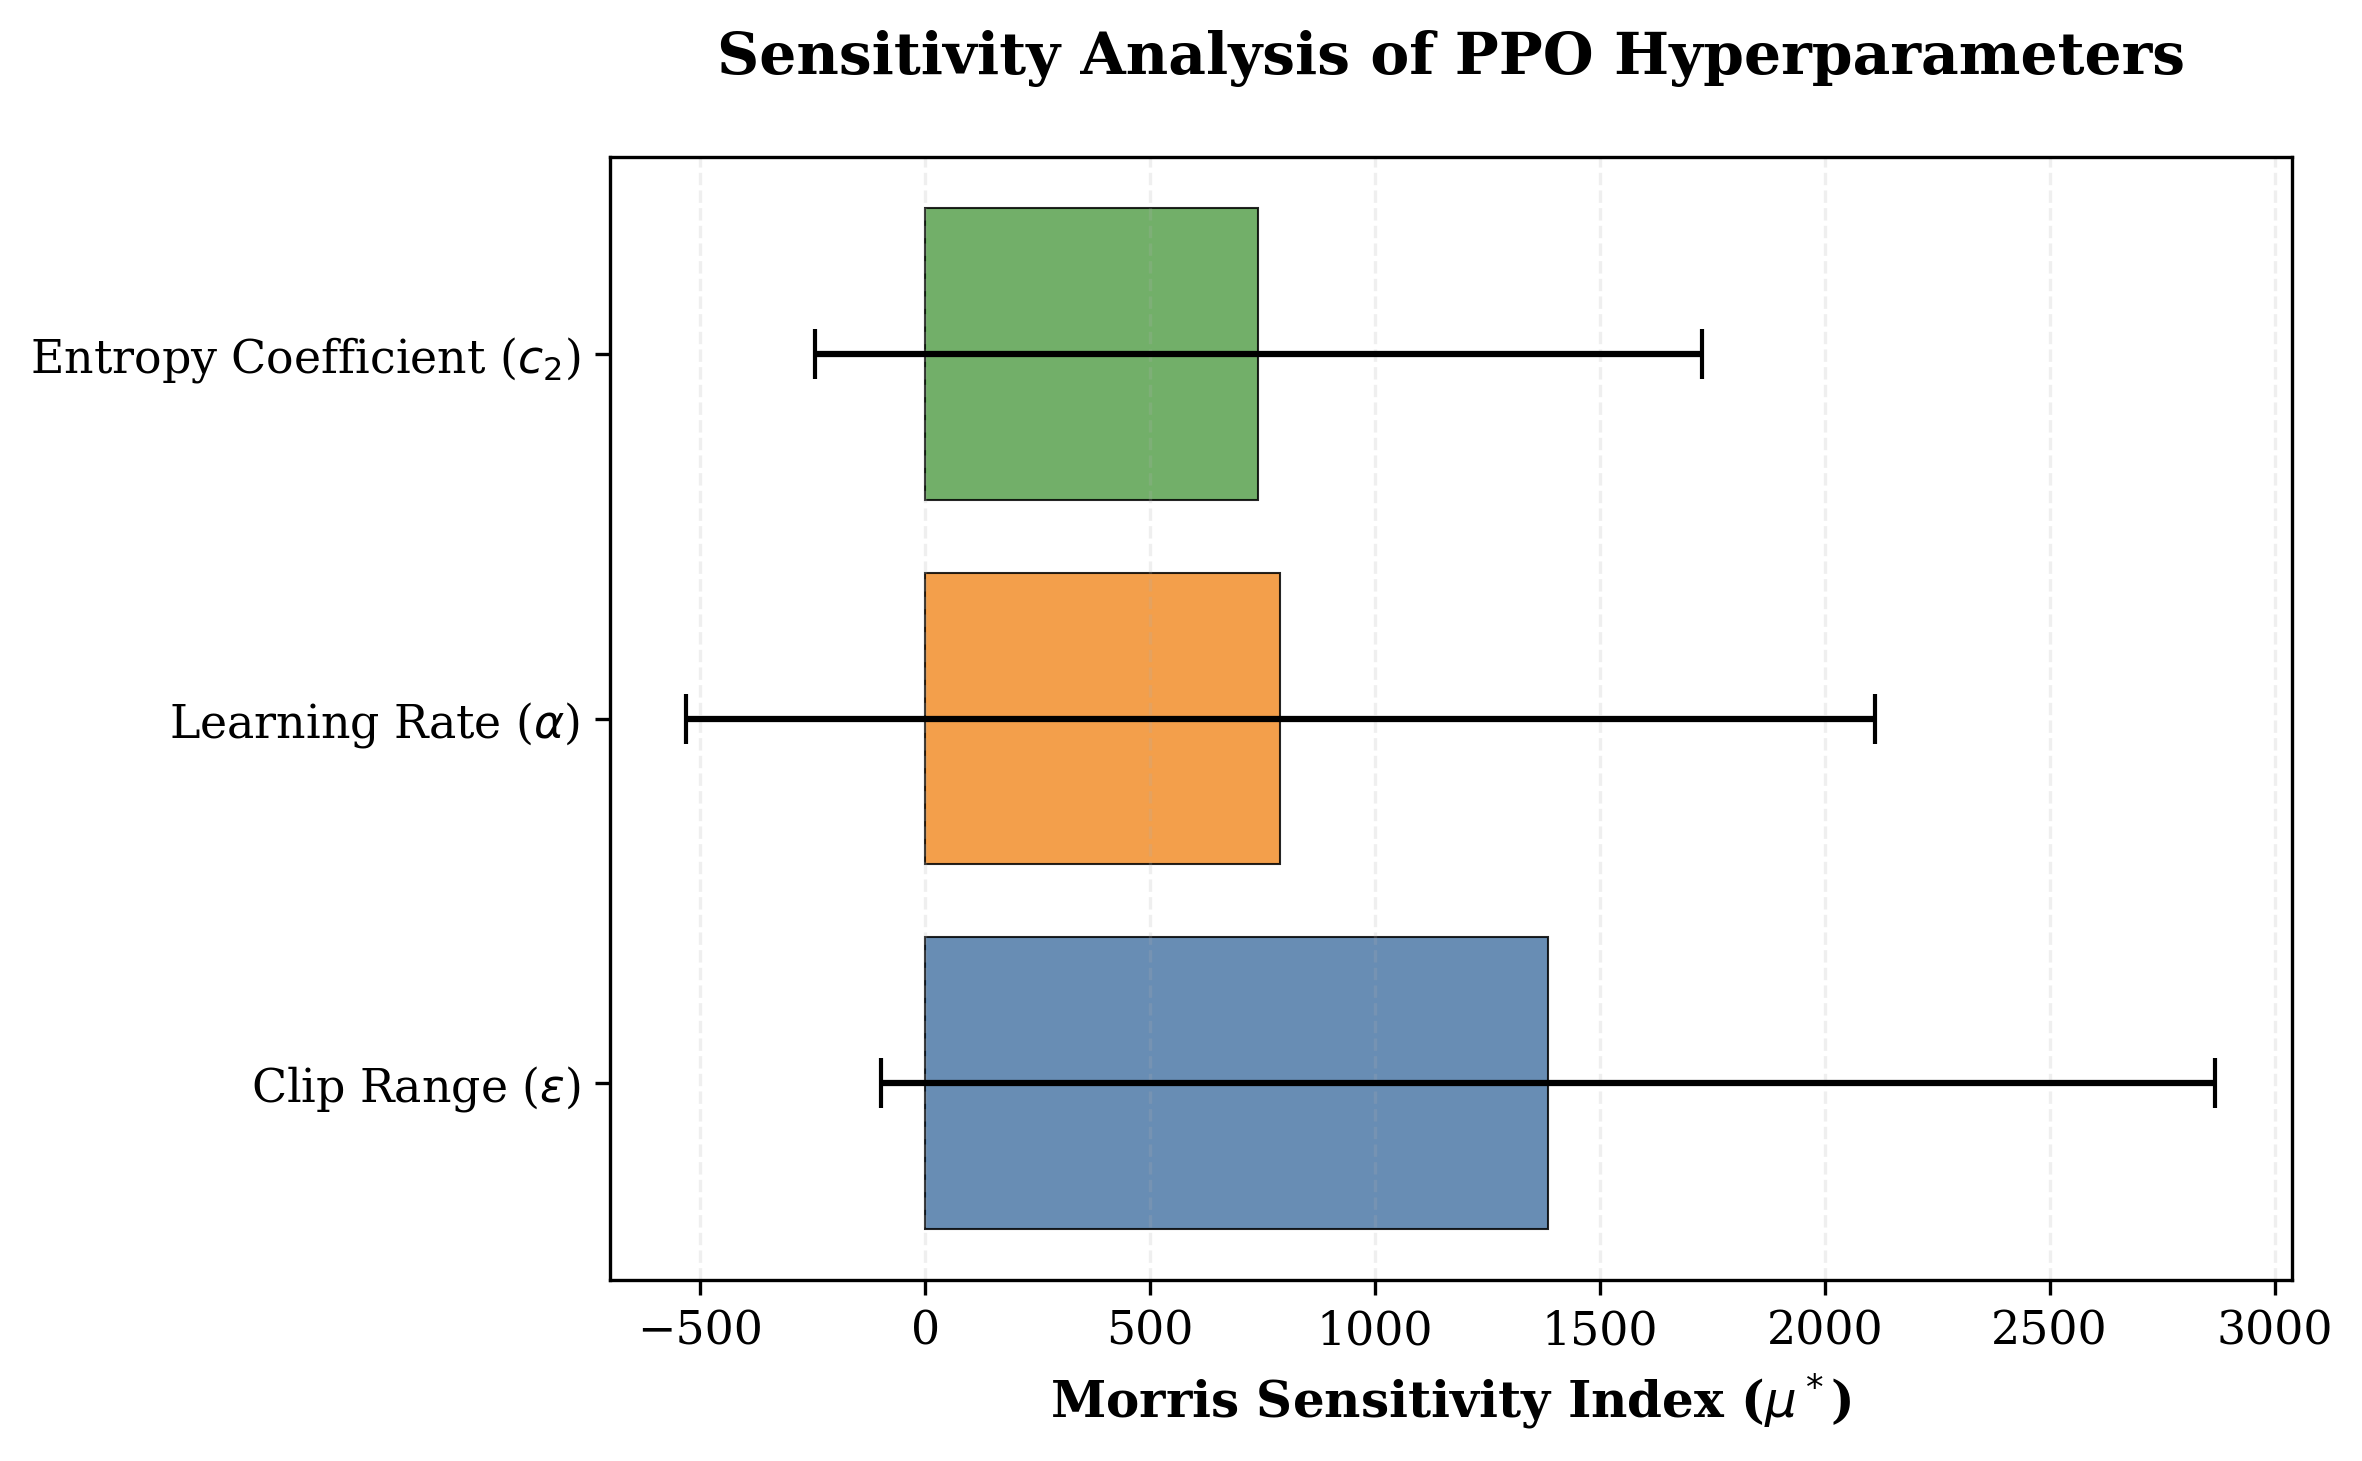

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Professional styling for academic publication
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.format': 'pdf'
})

parameters = ['Clip Range ($\\epsilon$)', 'Learning Rate ($\\alpha$)', 'Entropy Coefficient ($c_2$)']
mu_star = [1385.32, 789.59, 740.87]
sigma = [1482.95, 1321.10, 985.61]
colors = ['#4E79A7', '#F28E2B', '#59A14F']

fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal bar plot with error bars
y_pos = np.arange(len(parameters))
bars = ax.barh(y_pos, mu_star, xerr=sigma, capsize=6,
               color=colors, alpha=0.85, edgecolor='black', linewidth=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(parameters)
ax.set_xlabel('Morris Sensitivity Index ($\\mu^*$)', fontweight='bold')
ax.set_title('Sensitivity Analysis of PPO Hyperparameters',
             fontweight='bold', pad=20)

plt.grid(axis='x', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig('figure4_sensitivity_analysis.pdf')
plt.savefig('figure4_sensitivity_analysis.tiff', dpi=600)
plt.show()

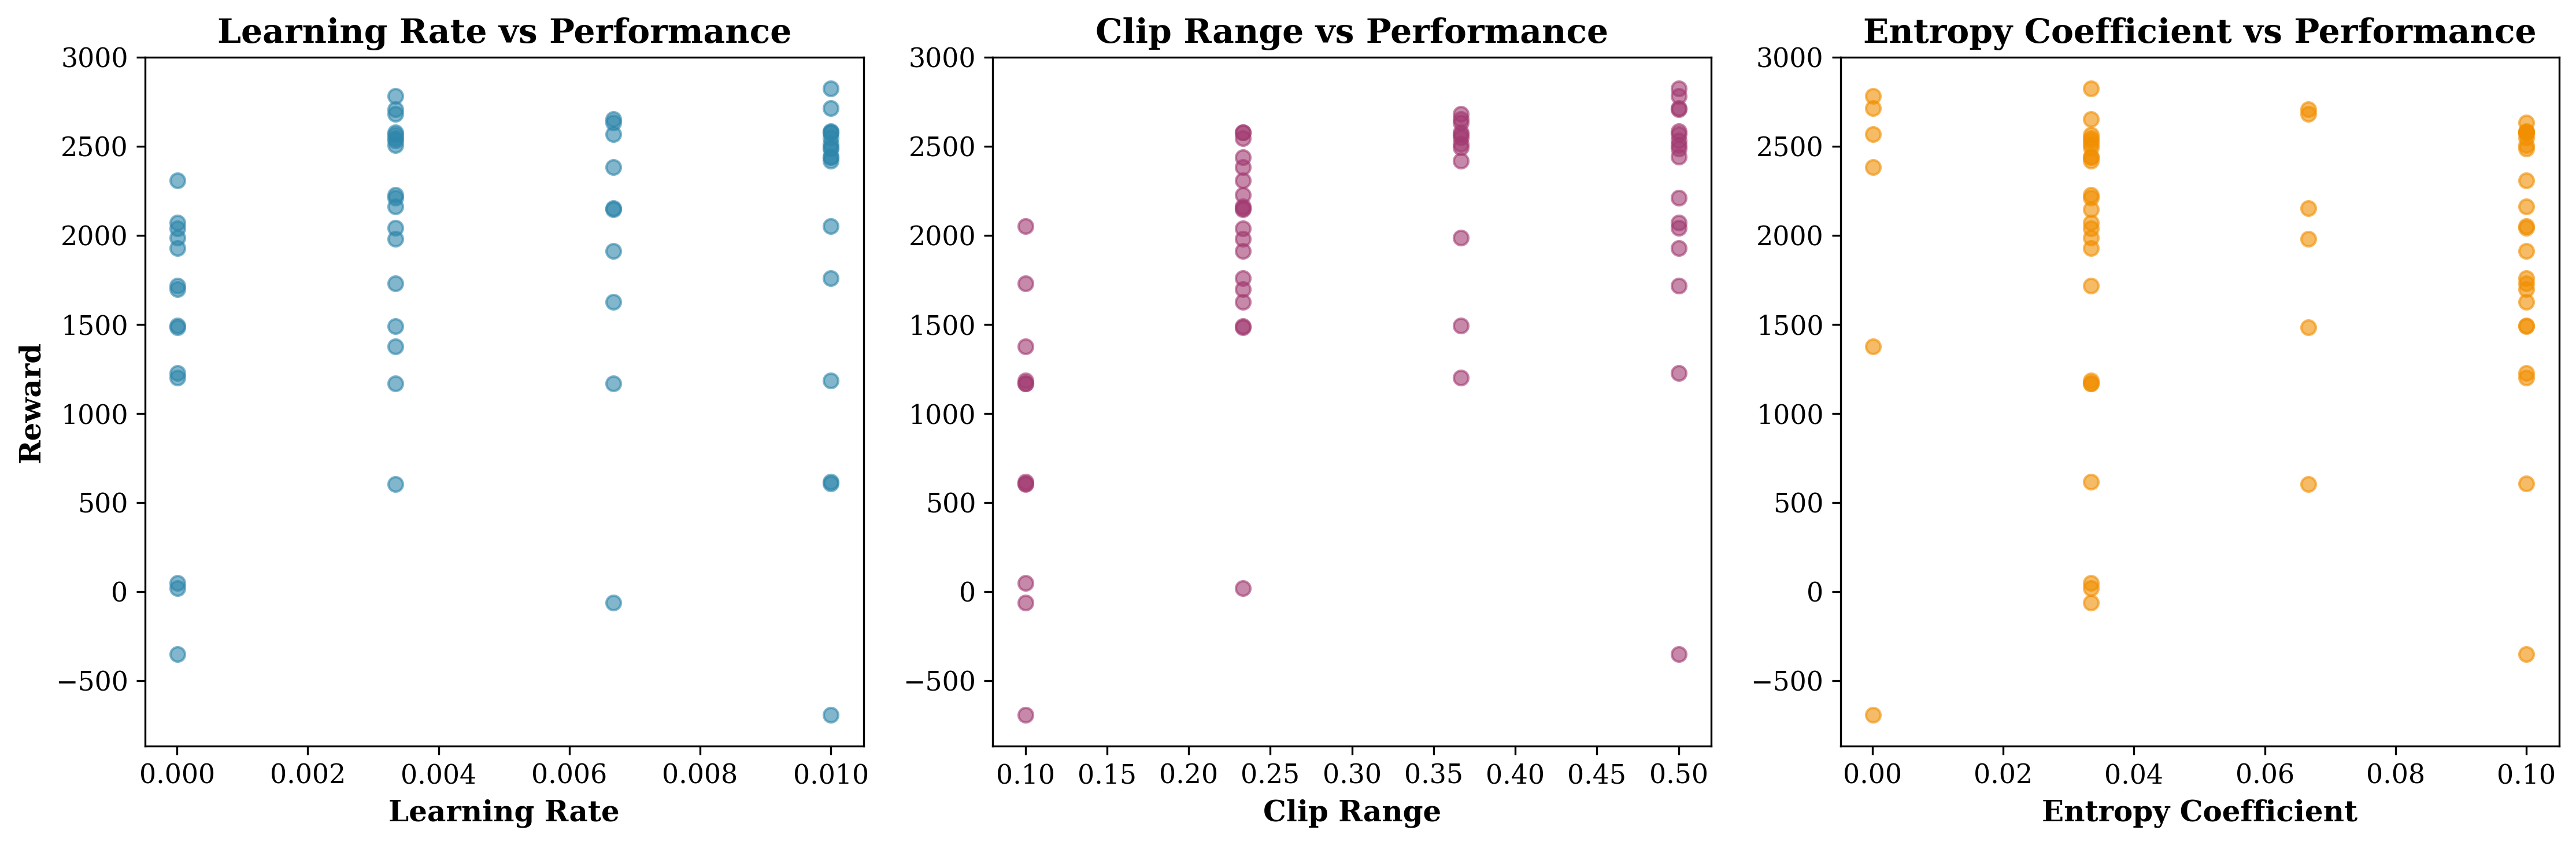

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Learning Rate vs Reward
axes[0].scatter(results_df['learning_rate'], results_df['reward'], alpha=0.6, color='#2E86AB')
axes[0].set_xlabel('Learning Rate', fontweight='bold')
axes[0].set_ylabel('Reward', fontweight='bold')
axes[0].set_title('Learning Rate vs Performance', fontweight='bold')

# Clip Range vs Reward
axes[1].scatter(results_df['clip_range'], results_df['reward'], alpha=0.6, color='#A23B72')
axes[1].set_xlabel('Clip Range', fontweight='bold')
axes[1].set_title('Clip Range vs Performance', fontweight='bold')

# Entropy Coefficient vs Reward
axes[2].scatter(results_df['entropy_coef'], results_df['reward'], alpha=0.6, color='#F18F01')
axes[2].set_xlabel('Entropy Coefficient', fontweight='bold')
axes[2].set_title('Entropy Coefficient vs Performance', fontweight='bold')

plt.tight_layout()
plt.savefig('parameter_reward_scatter.pdf', bbox_inches='tight')